# 单因子示例1：

价格因子验证，不考虑流通性和交易限制。
做分组收益统计与多空多冲


In [10]:
# 初始化设置
## 导入常用的包

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qdatasdk import *

##  设置回测参数

In [11]:
params = {
    # 开始时间
    "start_date": "2013-01-01",
    # 截止时间
    "end_date": "2019-12-31",
    # 再平衡周期(20个交易日)
    "adjust_days": 20,
    # 分组数量
    "group_number": 10,

    # 因子
    "factor": "Price"
}


# 加载历史数据

## 加载交易日

In [12]:
def load_trade_dates(start_date, end_date):
    """
    加载交易日数据
    :return: 回测期间所有的交易日
    """
    dates = get_trade_days(start_date, end_date)
    dates = sorted(dates)
    return dates


trade_dates = load_trade_dates(params["start_date"], params["end_date"])
trade_dates

[datetime.date(2013, 1, 4),
 datetime.date(2013, 1, 7),
 datetime.date(2013, 1, 8),
 datetime.date(2013, 1, 9),
 datetime.date(2013, 1, 10),
 datetime.date(2013, 1, 11),
 datetime.date(2013, 1, 14),
 datetime.date(2013, 1, 15),
 datetime.date(2013, 1, 16),
 datetime.date(2013, 1, 17),
 datetime.date(2013, 1, 18),
 datetime.date(2013, 1, 21),
 datetime.date(2013, 1, 22),
 datetime.date(2013, 1, 23),
 datetime.date(2013, 1, 24),
 datetime.date(2013, 1, 25),
 datetime.date(2013, 1, 28),
 datetime.date(2013, 1, 29),
 datetime.date(2013, 1, 30),
 datetime.date(2013, 1, 31),
 datetime.date(2013, 2, 1),
 datetime.date(2013, 2, 4),
 datetime.date(2013, 2, 5),
 datetime.date(2013, 2, 6),
 datetime.date(2013, 2, 7),
 datetime.date(2013, 2, 8),
 datetime.date(2013, 2, 18),
 datetime.date(2013, 2, 19),
 datetime.date(2013, 2, 20),
 datetime.date(2013, 2, 21),
 datetime.date(2013, 2, 22),
 datetime.date(2013, 2, 25),
 datetime.date(2013, 2, 26),
 datetime.date(2013, 2, 27),
 datetime.date(2013, 2, 

## 加载历史行情数据

In [13]:
def load_history(start_date, end_date):
    # 获取全市场标的: 沪、深两市
    df = get_all_securities()
    counter = 0
    total = len(df)
    data = {}
    for idx, row in df.iterrows():
        counter += 1
        # 回测截至日期之后还没有上市
        if row["start_date"] >= end_date:
            continue
        # 回测开始日期之前已经退市
        if row["end_date"] and row["end_date"] < start_date:
            continue
        security = idx
  
        bars = get_bars(security, start_date, end_date, unit="1d")
        data[security] = bars
        if counter % 100 == 0 or counter == total:
            print(f"loading history data: {round(counter * 100 / total, 2)}%")
    return data


# 获取不复权行情数据
history_data = load_history(trade_dates[0], trade_dates[-1])


loading history data: 1.96%
loading history data: 3.92%
loading history data: 5.88%
loading history data: 7.84%
loading history data: 9.81%
loading history data: 11.77%
loading history data: 13.73%
loading history data: 15.69%
loading history data: 17.65%
loading history data: 19.61%
loading history data: 21.57%
loading history data: 23.53%
loading history data: 25.5%
loading history data: 27.46%
loading history data: 29.42%
loading history data: 31.38%
loading history data: 33.34%
loading history data: 35.3%
loading history data: 37.26%
loading history data: 56.87%
loading history data: 58.84%
loading history data: 60.8%
loading history data: 62.76%
loading history data: 64.72%
loading history data: 66.68%
loading history data: 68.64%
loading history data: 70.6%
loading history data: 72.56%
loading history data: 74.52%
loading history data: 76.49%
loading history data: 78.45%
loading history data: 80.41%
loading history data: 82.37%
loading history data: 84.33%
loading history data: 9

In [24]:
# 查看数据
securities = list(history_data.keys())
print(len(securities))

# 检查数据
for security in securities:
    assert len(history_data[security]) > 0

security = securities[0]

history_data[security]

3797


,open,high,low,close,volume,money
date,,,,,,
2013-01-04,16.32,16.45,15.92,15.99,44385136.0,7.175676e+08
2013-01-07,15.98,16.35,15.88,16.30,35716924.0,5.784505e+08
2013-01-08,16.30,16.37,15.86,16.00,31247912.0,5.013601e+08
2013-01-09,15.96,16.02,15.80,15.86,25132916.0,3.996962e+08
2013-01-10,15.86,16.10,15.79,15.87,24003028.0,3.833477e+08
...,...,...,...,...,...,...
2019-12-25,16.45,16.56,16.24,16.30,41491798.0,6.796646e+08
2019-12-26,16.34,16.48,16.32,16.47,37203386.0,6.103818e+08
2019-12-27,16.53,16.93,16.43,16.63,104257472.0,1.741473e+09


## 复权处理

In [25]:
# 查询1支股票的复权因子
security = "000001.XSHE"
start_date = trade_dates[0]
end_date = trade_dates[-1]
fq_factors = get_adj_factors(security, start_date, end_date, fq="pre")
fq_factors

,factor
date,
2013-06-20,0.3177444409
2014-06-12,0.5129231709
2015-04-13,0.6239829556
2016-06-16,0.7554180692
2017-07-21,0.9199842102
2018-07-12,0.9334283005
2019-06-26,0.9481143542


In [26]:
# 获取收盘价
close = history_data[security]["close"]
close

date
2013-01-04    15.99
2013-01-07    16.30
2013-01-08    16.00
2013-01-09    15.86
2013-01-10    15.87
              ...  
2019-12-25    16.30
2019-12-26    16.47
2019-12-27    16.63
2019-12-30    16.57
2019-12-31    16.45
Name: close, Length: 1702, dtype: float64

In [27]:
from pandas import DataFrame, Series

# 复权处理: 收盘价做前复权

def fq(close, fq_factors):
    """
    获取复权[前复权]数据
    :param close: 收盘价序列
    :param fq_factors:  DataFrame类型: 复权因子序列
    :return: Series类型, 复权后的收盘价序列
    """
    if type(fq_factors) == DataFrame and len(fq_factors) > 0:
        # 复权价 = 累计前复权因子 * 不复权价
        factor = fq_factors["factor"]
        df = pd.concat([close, factor], sort=True, axis=1)
        # 只有除息日才有复权因子。除息日不需要复权, 所以把除息日的复权因子与除息日前一个交易日对齐。
        df['factor'] = df['factor'].shift(-1)
        # 使用除息日前一个交易日的复权因子, 填充该交易日之前的复权因子
        df = df.fillna(method="bfill")
        # 使用1填充,最近一个除息日、以及该除息日之后每个交易日的复权因子
        df = df.fillna(value=1)
        # 默认价格是np.float64类型，复权因子是float类型，计算前先做数据类型转换
        df["fq_close"] = df['close'] * (df["factor"].apply(np.float64))
        return df["fq_close"]
    else:
        return close.rename("fq_close")


fq_price = fq(close, fq_factors)
fq_price


2013-01-04     5.080734
2013-01-07     5.179234
2013-01-08     5.083911
2013-01-09     5.039427
2013-01-10     5.042604
                ...    
2019-12-25    16.300000
2019-12-26    16.470000
2019-12-27    16.630000
2019-12-30    16.570000
2019-12-31    16.450000
Name: fq_close, Length: 1702, dtype: float64

In [28]:
# 合并日K数据、复权数据
df = pd.concat([history_data[security], fq_price], sort=True, axis=1)
df

,open,high,low,close,volume,money,fq_close
date,,,,,,,
2013-01-04,16.32,16.45,15.92,15.99,44385136.0,7.175676e+08,5.080734
2013-01-07,15.98,16.35,15.88,16.30,35716924.0,5.784505e+08,5.179234
2013-01-08,16.30,16.37,15.86,16.00,31247912.0,5.013601e+08,5.083911
2013-01-09,15.96,16.02,15.80,15.86,25132916.0,3.996962e+08,5.039427
2013-01-10,15.86,16.10,15.79,15.87,24003028.0,3.833477e+08,5.042604
...,...,...,...,...,...,...,...
2019-12-25,16.45,16.56,16.24,16.30,41491798.0,6.796646e+08,16.300000
2019-12-26,16.34,16.48,16.32,16.47,37203386.0,6.103818e+08,16.470000
2019-12-27,16.53,16.93,16.43,16.63,104257472.0,1.741473e+09,16.630000


In [29]:
# 所有标的历史数据做前复权, 并且以日期为索引，合并日K、复权数据

start_date = trade_dates[0]
end_date = trade_dates[-1]

for security in history_data.keys():
    # 从API中获取复权因子
    fq_factors = get_adj_factors(security, start_date, end_date, fq="pre")
    bars = history_data[security]
    fq_price = fq(bars["close"], fq_factors)
    df = pd.concat([bars, fq_price], sort=True, axis=1)
    # 重新设置历史数据： 追加复权数据
    history_data[security] = df

In [30]:
# 检查数据： 已追加复权数据 fq_close
security = "000001.XSHE"
history_data[security]

,open,high,low,close,volume,money,fq_close
date,,,,,,,
2013-01-04,16.32,16.45,15.92,15.99,44385136.0,7.175676e+08,5.080734
2013-01-07,15.98,16.35,15.88,16.30,35716924.0,5.784505e+08,5.179234
2013-01-08,16.30,16.37,15.86,16.00,31247912.0,5.013601e+08,5.083911
2013-01-09,15.96,16.02,15.80,15.86,25132916.0,3.996962e+08,5.039427
2013-01-10,15.86,16.10,15.79,15.87,24003028.0,3.833477e+08,5.042604
...,...,...,...,...,...,...,...
2019-12-25,16.45,16.56,16.24,16.30,41491798.0,6.796646e+08,16.300000
2019-12-26,16.34,16.48,16.32,16.47,37203386.0,6.103818e+08,16.470000
2019-12-27,16.53,16.93,16.43,16.63,104257472.0,1.741473e+09,16.630000


## 从缓存的历史数据中快速查询 需要的日K数据

In [31]:
from datetime import datetime


def get_current_bar(security, date: datetime):
    """
    获取当前交易日K线数据
    :param security: 标的代码
    :param date: 指定日期
    :return: 日K数据, 字典类型
    """
    df = history_data.get(security)
    if type(df) == DataFrame and len(df) > 0:
        bars = df[df.index == date]
        if type(bars) == DataFrame and len(bars) > 0:
            return bars.iloc[0]


def get_last_bar(security, date: datetime):
    """
    获取最近一个交易日K线数据
    :param security: 标的代码
    :param date: 指定日期
    :return: 日K数据, 字典类型
    """
    df = history_data.get(security)
    if type(df) == DataFrame and len(df) > 0:
        bars = df[df.index <= date]
        if type(bars) == DataFrame and len(bars) > 0:
            return bars.iloc[-1]

In [32]:
security = "000001.XSHE"
get_current_bar(security, trade_dates[10])

open        1.787000e+01
high        1.842000e+01
low         1.760000e+01
close       1.833000e+01
volume      6.653676e+07
money       1.201752e+09
fq_close    5.824256e+00
Name: 2013-01-18, dtype: float64

In [33]:
get_last_bar(security, trade_dates[10])

open        1.787000e+01
high        1.842000e+01
low         1.760000e+01
close       1.833000e+01
volume      6.653676e+07
money       1.201752e+09
fq_close    5.824256e+00
Name: 2013-01-18, dtype: float64

# 因子检验 - 回测初始化

## 回测

### 编写回测伪码


1. 初始账户信息

    portfolio = {
    
        "net_value": 1, # 初始净值
    
        "positions": [],  # 初始持仓股票列表
    
        "stock_pool": [],  # 初始股票池
    
        "stats_datas": []  # 统计数据：所有调仓日的收益序列
    
    }


2. 每个交易日运行

    for date in trade_dates:
        # 不是调仓日，直接跳过
        if date not in adjust_dates:
            continue

        # 1. 平仓
        close(portfolio, date)

        # 2. 选股
        select(portfolio, date)

        # 3. 开仓
        open(portfolio, date)
        
    

### 功能实现

In [15]:
def init_adjust_dates(trade_dates, adjust_days):
    """
     初始化调仓日。
    :return:回测期间所有的调仓日
    """
    days = len(trade_dates)
    return [trade_dates[i] for i in range(0, days) if (i % adjust_days == 0) or (i == days - 1)]


def close(portfolio, date):
    """
    平仓
    :param portfolio: 账户信息
    :param date: 日期
    :return:
    """
    # 卖出
    # 不考虑流通性，认为所有股票都能买卖
    trades = []
    positions = portfolio["positions"]
    net_value = portfolio["net_value"]

    for position in positions:
        security = position["security"]
        # 如果持仓期间股票退市，就以退市前最后一个交易日收盘价平仓。
        bar = get_last_bar(security, date)
        last_price = bar["fq_close"]
        open_price = position["avg_cost"]
        # 计算个股收益率: 收盘价前复权 /开仓价 - 1
        r = last_price / open_price - 1
        trade = {"security": security, "open_date": position["date"], "open_price": open_price,
                 "close_date": bar.name, "close_price": last_price, "r": r}
        trades.append(trade)

        # print(trade)

    # 统计收益
    r_list = [t["r"] for t in trades]
    avg_r = 0 if len(r_list) == 0 else sum(r_list) / len(r_list)

    portfolio["net_value"] = net_value * (1 + avg_r)
    stats = {"date": date, "profit": net_value - 1, "trades":trades}

    # 更新上期收益
    portfolio["stats_datas"].append(stats)

    # 更新持仓：清空持仓股
    portfolio["positions"] = []


def select(portfolio, date, reverse=False, group_number=10):
    """
    选股
    :param group_number: 分组数量
    :param portfolio: 账户信息
    :param date: 日期
    :param reverse:因子排序, 默认从小到大
    :return:
    """
    # 获取当天正在交易的股票
    df = get_all_securities(date)

    all_stocks = [security for security in df.index]
    selected_stocks = []
    for security in all_stocks:
        bar = get_current_bar(security, date)
        if type(bar) != Series:
            continue
        selected_stock = {"security": security, "date": date, "factor_value": bar["close"], "price": bar["fq_close"]}
        selected_stocks.append(selected_stock)

    selected_stocks = sorted(selected_stocks, key=lambda x: x["factor_value"], reverse=reverse)
    # 本期选中的数量 =  每组的股票数量 - 持仓股数量
    size = int(len(all_stocks) / group_number)

    # 股票池
    selected_stocks = selected_stocks[:size]
    #     for selected_stock in selected_stocks:
    #         print(f"selected stock: date={date}, stock={selected_stock}")

    # 更新当期股票池
    portfolio["stock_pool"] = selected_stocks


def open(portfolio, date):
    """
    开仓
    :param portfolio: 账户信息
    :param date: 日期
    :return:
    """
    stock_pool = portfolio["stock_pool"]
    positions = portfolio["positions"]
    for selected in stock_pool:
        position = {"security": selected["security"], "date": date, "avg_cost": selected["price"]}
        # print(f"buy stock: date={date}, position={position}")
        positions.append(position)

    # 更新账户持仓
    portfolio["positions"] = positions
    # 清空股票池
    portfolio["stock_pool"] = []


##  第1组收益：定义回测函数，默认因子从小到大排序

In [16]:
def backtest(params):
    portfolio = {
        "net_value": 1,  # 初始净值
        "positions": [],  # 初始持仓股票列表
        "stock_pool": [],  # 初始股票池
        "stats_datas": []  # 收益统计：所有调仓日的收益序列
    }

    for date in trade_dates:
        if date not in adjust_dates:
            continue
        close(portfolio, date)
        select(portfolio, date, reverse=False, group_number=params["group_number"])
        open(portfolio, date)
    return portfolio


adjust_dates = init_adjust_dates(trade_dates, params["adjust_days"])
portfolio = backtest(params)

fdf = pd.DataFrame([{"date":d["date"], "profit":d["profit"] } for d in portfolio["stats_datas"]])
fdf


,date,profit
0,2013-01-04,0.000000
1,2013-02-01,0.000000
2,2013-03-08,0.057732
3,2013-04-09,0.130460
4,2013-05-10,0.105098
...,...,...
82,2019-09-30,3.826738
83,2019-11-04,3.767137
84,2019-12-02,3.699555
85,2019-12-30,3.693071


##  最后1组收益： 改写回测函数，支持因子排序设置

In [17]:
def backtest(params):
    portfolio = {
        "net_value": 1,  # 初始净值
        "positions": [],  # 初始持仓股票列表
        "stock_pool": [],  # 初始股票池
        "stats_datas": []  # 收益统计：所有调仓日的收益序列
    }

    # 从回测参数中获取排序
    reverse = False if params["sort"] == "asc" else True
    for date in trade_dates:
        if date not in adjust_dates:
            continue
        close(portfolio, date)
        select(portfolio, date, reverse=reverse, group_number=params["group_number"])
        open(portfolio, date)
    return portfolio


adjust_dates = init_adjust_dates(trade_dates, params["adjust_days"])
params["sort"] = "desc"
portfolio = backtest(params)
ldf = pd.DataFrame([{"date":d["date"], "profit":d["profit"] } for d in portfolio["stats_datas"]])
ldf

,date,profit
0,2013-01-04,0.000000
1,2013-02-01,0.000000
2,2013-03-08,0.054855
3,2013-04-09,0.098135
4,2013-05-10,0.072088
...,...,...
82,2019-09-30,1.650485
83,2019-11-04,1.768712
84,2019-12-02,1.859143
85,2019-12-30,1.757399


## 多空对冲

In [18]:
fdf["profit"] - ldf["profit"]

0     0.000000
1     0.000000
2     0.002877
3     0.032325
4     0.033010
        ...   
82    2.176253
83    1.998425
84    1.840412
85    1.935671
86    2.018600
Name: profit, Length: 87, dtype: float64

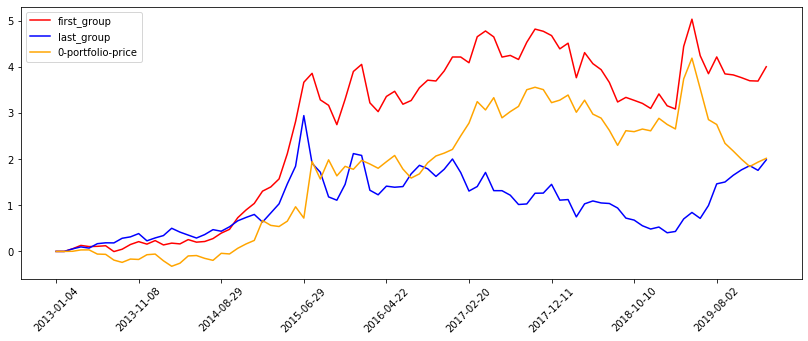

In [19]:
# 绘制收益曲线
# 设置画布大小
plt.figure(figsize=(14, 5))
# 设置X轴
# 如果显示的刻度有重叠，可以抽样显示刻度：X轴刻度的索引号
fg = fdf
lg = ldf

issue_number = len(fg)
x_ticks = np.arange(0, issue_number, 10)
# 设置X轴刻度
plt.xticks(x_ticks, rotation=45)
# 设置X轴数值
x_datas = list(fg["date"].map(lambda x: x.strftime("%Y-%m-%d")))

# 画图
plt.plot(x_datas, list(fg['profit']), color='r', label='first_group')
plt.plot(x_datas, list(lg['profit']), color='b', label='last_group')
plt.plot(x_datas, list(fg['profit'] - lg['profit']), color='orange', label='0-portfolio-price')
plt.legend(['first_group', 'last_group', '0-portfolio-price'])
plt.show()

# 记录运行日志，输出到文件中，使用logging替换print 

In [4]:
import logging
import os


def init_logging(log_name, level=logging.INFO):
    """
     初始化日志
    :param log_name: 日志文件名前缀，例如：日志文件名是factor_20230101.log, 其中的factor就是log_name
    :param level: 输出到文件中的日志级别。可选级别： 参考python的内置包logging
    :return:
    """
    # 生成日志存放在log目录下
    log_path = "log"
    if not os.path.exists(log_path):
        os.makedirs(log_path)
    date = datetime.now().strftime("%Y%m%d%H%M")

    # 定义日志输出格式
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

    logger = logging.getLogger()
    # 删除已经存在的handler: 避免在notebook环境下,init_logging运行多次，挂载多个相同handler,日志重复输出。
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)

    # 输出日志到文件中
    log_file = f"{log_path}/{log_name}_{date}.log"
    fh = logging.FileHandler(log_file, mode="w", encoding="utf8")
    fh.setFormatter(formatter)
    # 文件输出信息可以自定义
    fh.setLevel(level)
    logger.addHandler(fh)

    # 输出日志到当前控制台
    ch = logging.StreamHandler()
    ch.setFormatter(formatter)
    # 默认当前控制台只输出警告、异常信息
    # 注意： 控制台输出的日志如果太多，在jupyter环境下可能导致notebook无法正常加载
    ch.setLevel(level)
    logger.addHandler(ch)
    logger.setLevel(level)

In [5]:
init_logging("Price", level=logging.INFO)

NameError: name 'datetime' is not defined

In [22]:
logging.info(f"价格因子,第一组收益每期收益：{fdf['profit']}")

2023-02-25 14:43:30,352 INFO 价格因子,第一组收益每期收益：0     0.000000
1     0.000000
2     0.057732
3     0.130460
4     0.105098
        ...   
82    3.826738
83    3.767137
84    3.699555
85    3.693071
86    4.004069
Name: profit, Length: 87, dtype: float64
